Google Colab: https://colab.research.google.com/drive/1DOIOoSUj7CHB386dpCZqKWng7x3ls27v?usp=sharing

In [1]:
cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [2]:
ls

'Bank Customer Segmentation.ipynb'   sqli2.csv      sqlin_model.zip
'Copy of Assignment2.ipynb'          sqli.csv       Untitled1.ipynb
'Customer Segmentation.ipynb'        SQLin.ipynb
 first.ipynb                         sqlin_model/


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [4]:
df=pd.read_csv('sqli.csv', encoding='utf-16')
df.head()

,Sentence,Label
0,NaN,1
1,""" or pg_sleep ( __TIME__ ) --",1
2,create user name identified by pass123 tempora...,1
3,%29,1
4,' AND 1 = utl_inaddr.get_host_address ( ( S...,1


In [5]:
df2=pd.read_csv("sqli2.csv")
df2.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [6]:
print(df.shape)
print(df2.shape)

(33761, 2)
(30919, 2)


In [7]:
df['Sentence'] = df['Sentence'].astype(str)
df['Sentence'] = df['Sentence'].str.lower()
df['Label'] = pd.to_numeric(df['Label'], errors='coerce')
df['Label'] = df['Label'].astype('Int64')

In [8]:
df2['Query'] = df2['Query'].astype(str)
df2['Query'] = df2['Query'].str.lower()
df2['Label'] = pd.to_numeric(df2['Label'], errors='coerce')
df2['Label'] = df2['Label'].astype('Int64')

In [9]:
df.rename(columns={'Sentence': 'Query'}, inplace=True)
df.head()

,Query,Label
0,nan,1
1,""" or pg_sleep ( __time__ ) --",1
2,create user name identified by pass123 tempora...,1
3,%29,1
4,' and 1 = utl_inaddr.get_host_address ( ( s...,1


In [10]:
df.drop_duplicates()
df.dropna()

,Query,Label
0,nan,1
1,""" or pg_sleep ( __time__ ) --",1
2,create user name identified by pass123 tempora...,1
3,%29,1
4,' and 1 = utl_inaddr.get_host_address ( ( s...,1
...,...,...
33756,syrett,0
33757,arrechea bellveh,0
33758,1664,0
33759,almaluez,0


In [11]:
df2.drop_duplicates()
df2.dropna()

,Query,Label
0,""" or pg_sleep ( __time__ ) --",1
1,create user name identified by pass123 tempora...,1
2,and 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30914,delete from door where grow = 'small',0
30915,delete from tomorrow,0
30916,select wide ( s ) from west,0
30917,select * from ( select slide from breath ),0


In [12]:
n = min(len(df), len(df2))

sample_0 = df.sample(n=n, random_state=42)
sample_1 = df2.sample(n=n, random_state=27)

Final_df_ = pd.concat([sample_0, sample_1], ignore_index=True)
print(Final_df_.shape)
Final_df_.drop_duplicates()
print(Final_df_.shape)


(61838, 2)
(61838, 2)


In [13]:
Final_df_.head()

,Query,Label
0,häußler commented flood found gechingen unpre...,0
1,sean,0
2,lamarr@tardos.mobi,0
3,"-7069 ) union all select 6638,6638,6638,6638,...",1
4,4381135407580429,0


In [30]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, vectorizer):
        self.texts = texts
        self.labels = labels
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        text_vectorized = self.vectorizer.transform([text]).toarray()
        return torch.tensor(text_vectorized), torch.tensor(label)



textss = Final_df_['Query'].tolist()
labelss = Final_df_['Label'].tolist()

texts_train, texts_test, labels_train, labels_test = train_test_split(textss, labelss, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
vectorizer.fit(texts_train)

train_dataset = CustomDataset(texts_train, labels_train, vectorizer)
test_dataset = CustomDataset(texts_test, labels_test, vectorizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [15]:
test_loader

In [47]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        out = self.fc(hidden.squeeze(0))
        return out

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), lowercase=False)
vectorizer.fit(texts_train)
vocab_size = len(vectorizer.vocabulary_) + 1

def encode_text(text):
    tokens = text.split()
    return [vectorizer.vocabulary_.get(token, 0) for token in tokens]

train_encoded = [encode_text(text) for text in texts_train]
test_encoded = [encode_text(text) for text in texts_test]

max_len = 50
def pad_sequences(sequences, max_len):
    padded = torch.zeros((len(sequences), max_len), dtype=torch.long)
    for i, seq in enumerate(sequences):
        length = min(len(seq), max_len)
        padded[i, :length] = torch.tensor(seq[:length])
    return padded

X_train = pad_sequences(train_encoded, max_len)
y_train = torch.tensor(labels_train)

X_test = pad_sequences(test_encoded, max_len)
y_test = torch.tensor(labels_test)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = RNNClassifier(vocab_size, embed_dim=64, hidden_dim=32, output_dim=2)
rnn_model = rnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=1e-3)

rnn_model.train()
num_epochs = 4

for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {correct/total:.4f}")

rnn_model.eval()
eval_loss = 0.0
correct = 0
total = 0

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = rnn_model(inputs)

        loss = criterion(outputs, labels)
        eval_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

final_loss = eval_loss / len(test_loader)
rnn_final_acc = correct / total

print(f"RNN Evaluation Loss: {final_loss:.4f}")
print(f"RNN Evaluation Accuracy: {rnn_final_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
Epoch 1/4: 100%|██████████| 12368/12368 [00:39<00:00, 311.75it/s]


Epoch 1 | Loss: 7630.8581 | Accuracy: 0.6824


Epoch 2/4: 100%|██████████| 12368/12368 [00:41<00:00, 301.00it/s]


Epoch 2 | Loss: 7481.3119 | Accuracy: 0.6852


Epoch 3/4: 100%|██████████| 12368/12368 [00:38<00:00, 321.68it/s]


Epoch 3 | Loss: 7584.5325 | Accuracy: 0.6844


Epoch 4/4: 100%|██████████| 12368/12368 [00:39<00:00, 310.12it/s]


Epoch 4 | Loss: 6880.6440 | Accuracy: 0.6833


Evaluating: 100%|██████████| 3092/3092 [00:02<00:00, 1427.37it/s]

RNN Evaluation Loss: 0.4256
RNN Evaluation Accuracy: 0.7547


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class MLPClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.mean(dim=1)
        x = self.fc1(embedded)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


mlp_model = MLPClassifier(vocab_size, embed_dim=64, hidden_dim=4, output_dim=2)
mlp_model = mlp_model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-3)


mlp_model.train()
num_epochs = 4

for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"MLP Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"MLP Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {correct/total:.4f}")


mlp_model.eval()
eval_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="MLP Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mlp_model(inputs)

        loss = criterion(outputs, labels)
        eval_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

final_loss = eval_loss / len(test_loader)
final_acc = correct / total

print(f"MLP Evaluation Loss: {final_loss:.4f}")
print(f"MLP Evaluation Accuracy: {final_acc:.4f}")


MLP Epoch 1/4: 100%|██████████| 12368/12368 [00:32<00:00, 376.60it/s]


MLP Epoch 1 | Loss: 3976.8581 | Accuracy: 0.7988


MLP Epoch 2/4: 100%|██████████| 12368/12368 [00:31<00:00, 389.32it/s]


MLP Epoch 2 | Loss: 3282.5855 | Accuracy: 0.8274


MLP Epoch 3/4: 100%|██████████| 12368/12368 [00:32<00:00, 383.28it/s]


MLP Epoch 3 | Loss: 3245.9540 | Accuracy: 0.8300


MLP Epoch 4/4: 100%|██████████| 12368/12368 [00:31<00:00, 387.78it/s]


MLP Epoch 4 | Loss: 3220.1578 | Accuracy: 0.8295


MLP Evaluating: 100%|██████████| 3092/3092 [00:01<00:00, 1844.90it/s]

MLP Evaluation Loss: 0.0283
MLP Evaluation Accuracy: 0.9944


In [40]:
print(f"Length of texts: {len(textss)}")
print(f"Length of labels: {len(labelss)}")


Length of texts: 61838
Length of labels: 61838


In [34]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labelss': torch.tensor(label, dtype=torch.long)
        }

texts_train_bert, texts_test_bert, labels_train_bert, labels_test_bert = train_test_split(textss, labelss, test_size=0.2, random_state=42)

train_dataset_bert = CustomDataset(texts_train_bert, labels_train_bert, tokenizer)
test_dataset_bert = CustomDataset(texts_test_bert, labels_test_bert, tokenizer)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=4, shuffle=True)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=4, shuffle=False)



In [39]:
from transformers import DistilBertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import gc

gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()
num_epochs = 4

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in tqdm(train_loader_bert, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labelss'].to(device)

        optimizer.zero_grad()


        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits


        _, predicted = torch.max(logits, dim=1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_accuracy = correct_preds / total_preds
    print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.4f}")



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/4: 100%|██████████| 12368/12368 [12:51<00:00, 16.02batch/s]


Epoch 1/4 | Loss: 191.5841 | Accuracy: 0.9958


Epoch 2/4: 100%|██████████| 12368/12368 [12:35<00:00, 16.36batch/s]


Epoch 2/4 | Loss: 70.7248 | Accuracy: 0.9987


Epoch 3/4: 100%|██████████| 12368/12368 [12:36<00:00, 16.34batch/s]


Epoch 3/4 | Loss: 56.5831 | Accuracy: 0.9990


Epoch 4/4: 100%|██████████| 12368/12368 [12:38<00:00, 16.31batch/s]

Epoch 4/4 | Loss: 35.0902 | Accuracy: 0.9992


In [46]:
model.eval()
eval_loss = 0.0
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for batch in tqdm(test_loader_bert, desc='Evaluation', unit='batch'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labelss'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        eval_loss += loss.item()

eval_accuracy = correct_preds / total_preds
print(f'\nEvaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy:.4f}')


Evaluation: 100%|██████████| 3092/3092 [00:48<00:00, 63.14batch/s]


Evaluation Loss: 12.1305, Evaluation Accuracy: 0.9989


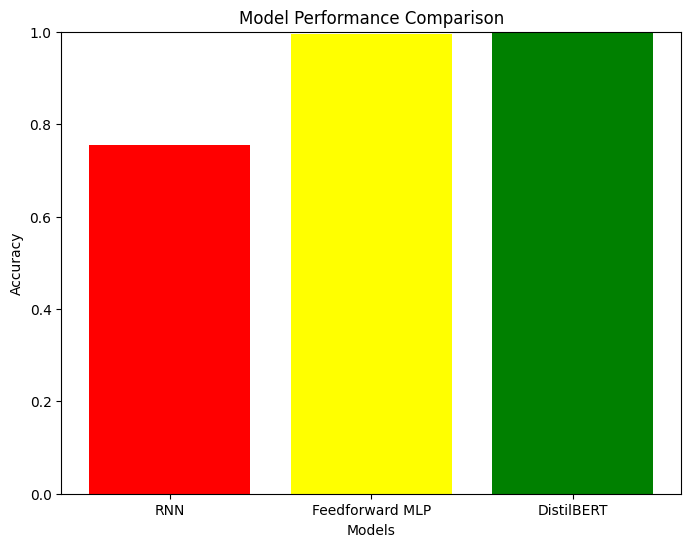

In [63]:
import matplotlib.pyplot as plt

models = ['RNN', 'Feedforward MLP', 'DistilBERT']
accuracies = [rnn_final_acc, final_acc, eval_accuracy]


plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['red', 'yellow', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.show()


In [ ]:
from transformers import DistilBertTokenizer

model.save_pretrained("sqlin_model")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.save_pretrained("sqlin_model")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

('sqlin_model/tokenizer_config.json',
 'sqlin_model/special_tokens_map.json',
 'sqlin_model/vocab.txt',
 'sqlin_model/added_tokens.json')

In [ ]:
import shutil
shutil.make_archive("sqlin_model", 'zip', "sqlin_model")

'/content/drive/MyDrive/Colab Notebooks/sqlin_model.zip'

In [ ]:
from google.colab import files
files.download("sqlin_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>